## Import packages

Let's start by importing the required packages. The `os` package is used to read files and directory structure, NumPy is used to convert python list to numpy array and to perform required matrix operations and `matplotlib.pyplot` to plot the graph and display images in the training and validation data.

In [1]:
import warnings  
warnings.filterwarnings("ignore",category=FutureWarning)

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'1.14.0'

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [5]:
train_dir = 'asl_alphabet_train'
validation_dir = 'asl_alphabet_test'

In [6]:
sign_list = os.listdir('asl_alphabet_train')

In [7]:
for sign in sign_list:
    X = y = os.listdir('asl_alphabet_train' + f'/{sign}')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    print(X_train[:4]) # in order to demonstrate the shuffling

['A2758.jpg', 'A2005.jpg', 'A2067.jpg', 'A2058.jpg']
['B139.jpg', 'B346.jpg', 'B2582.jpg', 'B1597.jpg']
['C2011.jpg', 'C225.jpg', 'C1010.jpg', 'C1496.jpg']
['D841.jpg', 'D1695.jpg', 'D2440.jpg', 'D2935.jpg']
['E1071.jpg', 'E510.jpg', 'E1606.jpg', 'E1114.jpg']
['F1595.jpg', 'F2238.jpg', 'F2292.jpg', 'F2392.jpg']
['G1305.jpg', 'G195.jpg', 'G2719.jpg', 'G1922.jpg']
['H167.jpg', 'H103.jpg', 'H322.jpg', 'H576.jpg']
['I1774.jpg', 'I2544.jpg', 'I2248.jpg', 'I1460.jpg']
['J922.jpg', 'J465.jpg', 'J1429.jpg', 'J1057.jpg']
['K2638.jpg', 'K1125.jpg', 'K1467.jpg', 'K2346.jpg']
['L2532.jpg', 'L789.jpg', 'L641.jpg', 'L2758.jpg']
['M756.jpg', 'M2204.jpg', 'M2900.jpg', 'M1291.jpg']
['N806.jpg', 'N1159.jpg', 'N1243.jpg', 'N1376.jpg']
['nothing1253.jpg', 'nothing805.jpg', 'nothing1580.jpg', 'nothing2078.jpg']
['O1081.jpg', 'O1872.jpg', 'O1705.jpg', 'O464.jpg']
['P921.jpg', 'P1056.jpg', 'P1646.jpg', 'P2771.jpg']
['Q2670.jpg', 'Q489.jpg', 'Q305.jpg', 'Q1831.jpg']
['R1136.jpg', 'R2728.jpg', 'R1689.jpg', 'R4

In [8]:
"""This cell should not be run more than once"""
# for sign in class_list:
#     X = y= os.listdir('asl_alphabet_train' + f'/{sign}')
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
#     for x in X_test:
#         os.rename('asl_alphabet_train' + f'/{sign}/{x}', 'asl_alphabet_test' + f'/{sign}/{x}')

'This cell should not be run more than once'

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [9]:
batch_size = 128
epochs = 200
IMG_HEIGHT = 200
IMG_WIDTH = 200

## Data augmentation

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [10]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [11]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 71400 images belonging to 28 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [13]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

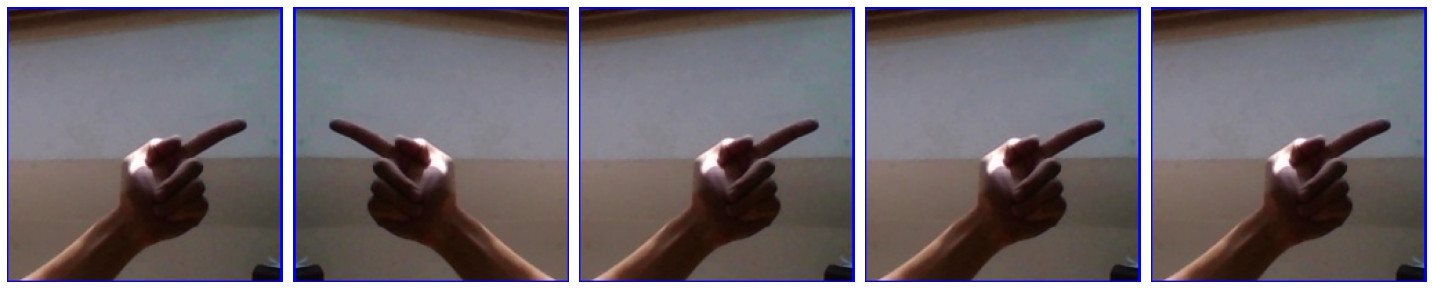

In [14]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [16]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 71400 images belonging to 28 classes.


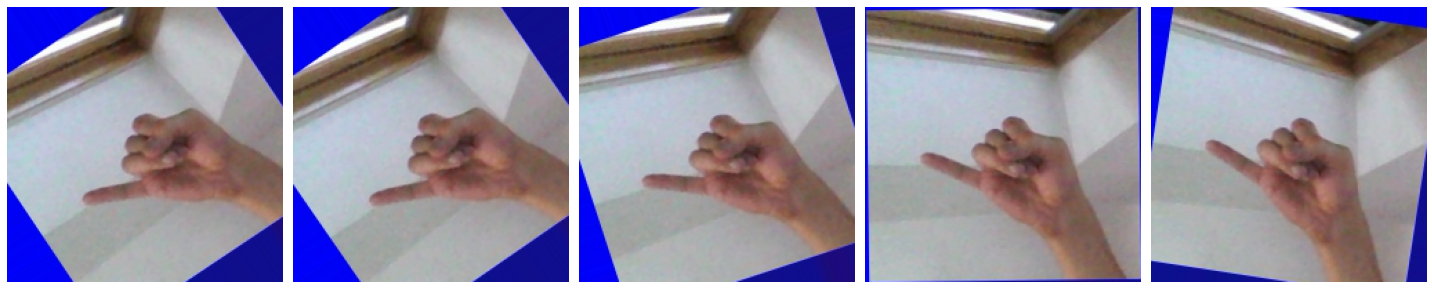

In [17]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [18]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [19]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 71400 images belonging to 28 classes.


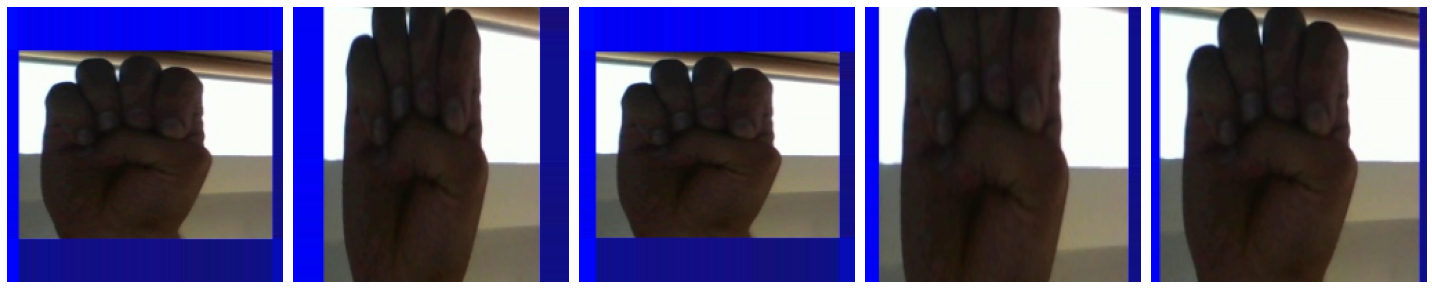

In [20]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations. Here, we applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [21]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [22]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 71400 images belonging to 28 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

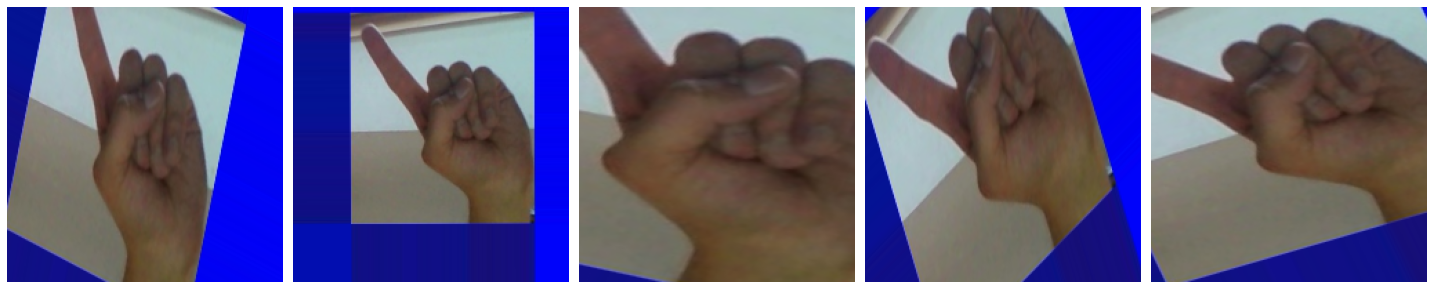

In [23]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [24]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [25]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 12628 images belonging to 28 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples.

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

## Creating a new network with Dropouts

Here, we apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset.

In [32]:
model_new = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(800, activation='relu'),
    Dense(28, activation='softmax')
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [33]:
model_new.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 16)       

## Establish callbacks to regulate training

In [34]:
callbacks = [EarlyStopping(monitor='val_acc', patience=15), ModelCheckpoint('training_model', save_best_only=True)]

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [ ]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=71400 // batch_size,
    epochs=1000,
    validation_data=val_data_gen,
    validation_steps=12601 // batch_size,
    callbacks=callbacks
)

In [ ]:
label = round(max(history.history['val_acc']), 3)
model_new.save(f'{label}_val_acc')

### Visualize the model

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()